In [1]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from experiments.feat_att_minigrid.n_room_env import FourRoomEnv
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from cnn import MinigridFeaturesExtractor
from stable_baselines3.common.utils import obs_as_tensor

pygame 2.5.2 (SDL 2.28.3, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [85]:
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 5e5,
    "env_name": "Four-Room",
    "feat_dim":32,
}
# load agent
# model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/8qilkcik/model") # 32 dim feats
# model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/f8e0x616/model") # 16 dim feats
model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/df6wgaan/model") # 12 dim feats
def make_env():
    env = FourRoomEnv(render_mode="rgb_array")
    env = FullyObsWrapper(env)
    env = ImgObsWrapper(env)
    env = Monitor(env)
    return env

def pre_process_obs(obs, model):
    obs = np.transpose(obs, (0,3,1,2)) # bring colour channel to front
    return obs_as_tensor(obs, model.policy.device)

def get_hallway_obs(env, see_obs=False):
    # # Vector Action Encoding:
    # 0 = left
    # 1 = right
    # 2 = forward

    obs = env.reset() # initial obs
    obs_list = []

    # start to north hallway
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    #going through first hallway
    obs, _, _, _ = env.step([0])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    # going back the way we came
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)

    # go to the east hallway
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)

    # go to the south hallway
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)

    # go to the west hallway
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)

    if see_obs:
        img = env.render()
        plt.imshow(np.concatenate([img], 1)) # shows the full environment
        plt.show()
    
    return obs_list

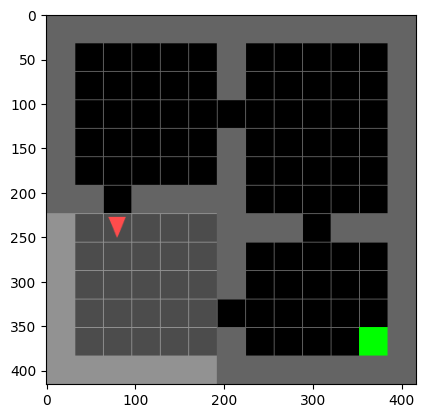

In [86]:
env = DummyVecEnv([make_env])
obs = env.reset()
obs_list = get_hallway_obs(env, see_obs=True)

In [87]:
max_feat_list = []
feature_activations = []

with torch.no_grad():
    for obs in obs_list:
        obs = pre_process_obs(obs, model)
        x = model.policy.extract_features(obs)
        max_feat_list.append(torch.argmax(x).item())
        feature_activations.append(x.reshape(1, -1))

feature_activations = torch.cat(feature_activations, dim=0)

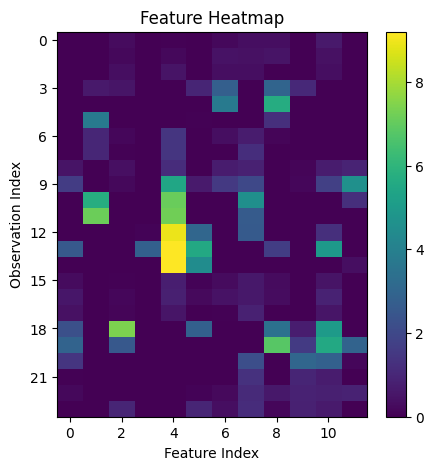

In [88]:
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.imshow(feature_activations, cmap='viridis', aspect='auto')
# y_tick_positions = [i * 56 for i in range(785 // 56)] # 16 by 16
y_tick_positions = [i * 3 for i in range(24 // 3)]
plt.yticks(y_tick_positions)
plt.colorbar()
plt.xlabel('Feature Index')
plt.ylabel('Observation Index')
plt.title('Feature Heatmap')
plt.show()